# Using Symptoms to Predict the Sex of an Individual with Heart Disease
Dsci 100-006, Group 2, 
By: Lauren Williams (40301228),
Harmandeep Singh (80027824),
Chloe de Weerdt (30733018),
Skyler Tanahara (80279326)


## Introduction

Can the sex of an individual who is diagnosed with heart disease be accurately predicted by age and cholesterol level?

Heart disease is the leading cause of death worldwide, manifested when the heart and blood vessels are compromised. It is characterized by the plaque build up around blood vessels, restricting blood flow to the heart. High blood pressure, smoking, obesity, high cholesterol, and inactivity are common factors that contribute to the development of cardiovascular disease. It is important to highlight that symptoms and risk factors differ significantly between men and women. Due to these differences, can the sex of the patient be predicted by the symptoms they present in response to cardiovascular diseases, particularly their age and cholesterol levels? To answer this question, the “International application of a new probability algorithm for the diagnosis of coronary artery disease” dataset will be used. The data set provides a variables table regarding the patient’s symptoms. We will use age and cholesterol levels as our predictors to identify the sex of the patient. 


In [18]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)

options(repr.matrix.max.rows = 10)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales:

In [27]:
library(readr)

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

read_data <- read_csv(url, col_names = FALSE)

heart_data <- read_data |>

    mutate(age = X1,  chol = X5, sex = X2, cp = X3) |>
    select(age, chol, sex, cp) |>
    mutate(sex = ifelse(sex == 1, "male", "female")) #|>  #use to change cp values to names of cp type for graph if we use 
                                                          #facet wrap or predict cp type
    #mutate(cp = recode(cp, "1" = "typical angina", "2" = "atypical angina", "3" = "non-anginal pain", "4" = "asymptomatic"))
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,chol,sex,cp
<dbl>,<dbl>,<chr>,<dbl>
63,233,male,1
67,286,male,4
67,229,male,4
37,250,male,3
41,204,female,2
56,236,male,2


## Preliminary exploratory data analysis:



In [20]:
set.seed(4321)

heart_split1 <- initial_split(heart_data, prop = 0.75, strata = sex)
heart_train1 <- training(heart_split1)

age_count <- heart_train1 |>
            reframe(unique(age)) |>
            nrow()

col_count <- heart_train1 |>
            reframe(unique(chol)) |>
            nrow()
   
sex_count <- heart_train1 |>
            reframe(unique(sex)) |>
            nrow()

summary_table <- heart_train1 |>
    select(age, chol) |>
    mutate("Rows with Missing Data" = sum(is.na(age) | is.na(chol))) |>
    map_df(mean) |>
    mutate("Number of Sex Observations" = sex_count,
           "Number of Cholesterol Observations" = col_count, 
           "Number of Age Observations" = age_count) |>
    rename("Cholesterol Average" = chol, "Age Average" = age) 
    
    
summary_table

Age Average,Cholesterol Average,Rows with Missing Data,Number of Sex Observations,Number of Cholesterol Observations,Number of Age Observations
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
54.4115,249.3186,0,2,128,40


## Methods:

The columns for age "age" and cholesterol "chol" will be used to create a model that will predict the class "sex".

A scatterplot graph will be generated with colourcoding for the class (sex) from the training data.

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



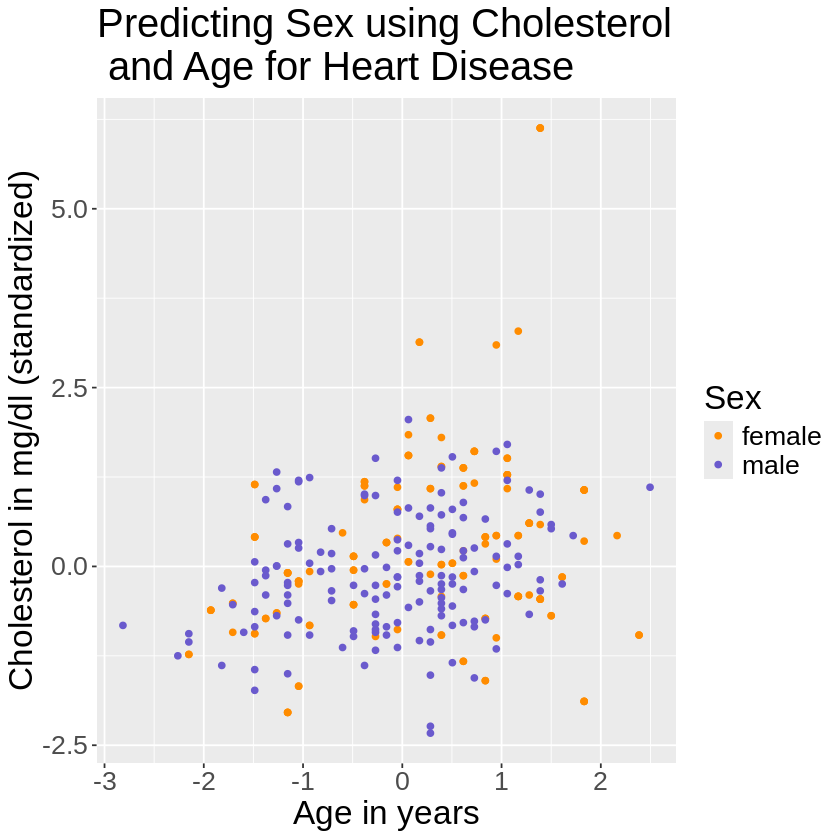

In [25]:
install.packages("themis")
library(themis)

set.seed(4321)

heart_data_recipe <- recipe(sex ~ age + chol, data = heart_data) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) |> 
                        step_upsample(sex, over_ratio = 1, skip = FALSE) |> 
                        prep() |> 
                        bake(heart_data)

heart_split <- initial_split(heart_data_scaled, prop = 0.75, strata = sex)  
heart_train <- training(heart_split)
heart_test <- testing(heart_split)


heart_plot <- heart_train |>
    ggplot(aes(x = age, y = chol))+
        geom_point(aes(color = sex)) +
        labs(x = "Age in years", y = "Cholesterol in mg/dl (standardized)",
             color = "Sex", title = "Predicting Sex using Cholesterol \n and Age for Heart Disease") +
        scale_colour_manual(values = c("darkorange", "slateblue")) +
        theme(text = element_text(size = 20)) 

heart_plot

## Expected Outcomes and Significance:

As you increase with age we predict that the individual with heart disease is more likely to be female. Before menopause, women tend to have a lower risk of heart disease compared to men of the same age. This is partially attributed to the protective effects of estrogen, a hormone that may have beneficial effects on the cardiovascular system. However, after menopause, when estrogen levels decline, the risk of heart disease in women increases, and it can approach or even surpass the risk in men of similar age. Therefore, individuals that are older in age with heart disease are more likely to be female as their hormone levels change through menopause, and individuals with heart disease at younger ages are more likely to be male. Using the predictor cholesterol, we think higher cholesterol levels are more likely to be male. This is due to gender-specific lifestyles. Due to social stigma, females tend to maintain a healthier diet and a more active lifestyle whereas men tend to live a more sedentary life. These differences in activity, therefore, provide us with relative cholesterol levels allowing us to predict the sex of an individual. 
Knowing the differences between the age of onset and cholesterol levels for heart disease between men and women would help us build better protocols and guidelines that are catered to the sex of the individual. Current research is mainly focused on the male population and differences between sex are often not taken into account, believing that male findings are applicable to women. Knowing that women have a higher chance of heart disease postmenopause would allow us to encourage women to go for regular check-ups postmenopause.
Further questions could arise from data analysis like ours:
Are the sex-specific risk factors that contribute to the development of heart disease? Do treatments for heart disease have different effectiveness or side effects in men and women? How can treatment strategies be tailored to the specific needs of each gender?
